In [37]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio
import hydromt

from pathlib import Path
from osgeo import gdal
from hydromt_sfincs import SfincsModel
from rasterio.mask import mask
from matplotlib.colors import ListedColormap, BoundaryNorm

In [32]:
# Define your custom colors for floodmaps
colors = ['blue', 'lightblue', 'white', 'grey']
cmap = ListedColormap(colors)
bounds = np.array([-1.5, -0.5, 0.5, 1.5, 2.5])
norm = BoundaryNorm(bounds, cmap.N)

### Models
Load all models and results and add them to a dictionary:

In [2]:
model_names = os.listdir(Path("model"))
models = {}
results = {}
for model_name in model_names:
    model = SfincsModel(fr"model/{model_name}/", mode="r")
    model.read_results()
    
    models[model_name] = model
    results[model_name] = model.results

In [3]:
# We append 1 model as the base model, with a representative grid.
mod0 = models["garissa_depth3m_fabdem_grid100"]
print(mod0.grid)

<xarray.Dataset> Size: 465kB
Dimensions:      (y: 243, x: 211)
Coordinates:
  * y            (y) float64 2kB -6.356e+04 -6.346e+04 ... -3.946e+04 -3.936e+04
  * x            (x) float64 2kB 4.402e+06 4.403e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 4B 0
Data variables:
    msk          (y, x) uint8 51kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    scs          (y, x) float32 205kB -9.999e+03 -9.999e+03 ... -9.999e+03
    dep          (y, x) float32 205kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:  0


### Flood maps
Load and plot the available flood maps:

In [4]:
# Available floodmaps
floodmap_names = {
"opera":[
    "2023-11-11",
    "2023-11-21",
    "2023-11-29",
],
"unosat":[
    "2023-11-26",
    "2023-12-01",
]}
print(floodmap_names)

{'opera': ['2023-11-11', '2023-11-21', '2023-11-29'], 'unosat': ['2023-11-26', '2023-12-01']}


In [46]:
# Each dataset has its own defined conventions, so we need to pre-process the data
# clouds:-1, no water:0, permanent water:1, flood:2.
data_map = {
    "opera":{
        "2023-11-11":{-4:1, 1:1, -3:-1},
        "2023-11-21":{-4:1, 1:1, -3:-1},
        "2023-11-29":{-3:-1, -1:-1, 1:1},
    },
    "unosat":{
        "2023-11-26":{},
        "2023-12-01":{},
    }
}

def map_values(map, array):
    values_in_map = np.unique(array)
    for 
    return

In [44]:
analysis_extent_path = Path(r"data/2_floodmaps/analysis_extent_garissa.shp")
analysis_extent = gpd.read_file(analysis_extent_path)

### Raster floodmap
OPERA has a raster format.

<xarray.DataArray 'data' (y: 243, x: 211)> Size: 51kB
array([[-3, -3, -3, ..., -3, -3, -3],
       [-3, -3, -3, ..., -3, -3, -3],
       [-3, -3, -3, ..., -3, -3, -3],
       ...,
       [ 0,  0,  0, ..., -3, -3, -3],
       [ 0,  0,  0, ..., -3, -3, -3],
       [ 0,  0,  0, ..., -3, -3, -3]], dtype=int8)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float64 2kB 4.402e+06 4.403e+06 ... 4.423e+06 4.423e+06
  * y            (y) float64 2kB -6.356e+04 -6.346e+04 ... -3.946e+04 -3.936e+04
Attributes: (12/46)
    ACCODE:                                                                  ...
    AEROSOL_CLASS_REMAPPING_ENABLED:                                         ...
    AEROSOL_NOT_WATER_TO_HIGH_CONF_WATER_FMASK_VALUES:                       ...
    AEROSOL_PARTIAL_SURFACE_AGGRESSIVE_TO_HIGH_CONF_WATER_FMASK_VALUES:      ...
    AEROSOL_PARTIAL_SURFACE_WATER_CONSERVATIVE_TO_HIGH_CONF_WATER_FMASK_VALUE...
    AEROSOL_WATER_MODERATE_CONF_TO_HIGH_CONF_WATER_FMASK_VALUES:     

AttributeError: 'DataArray' object has no attribute 'ravel'

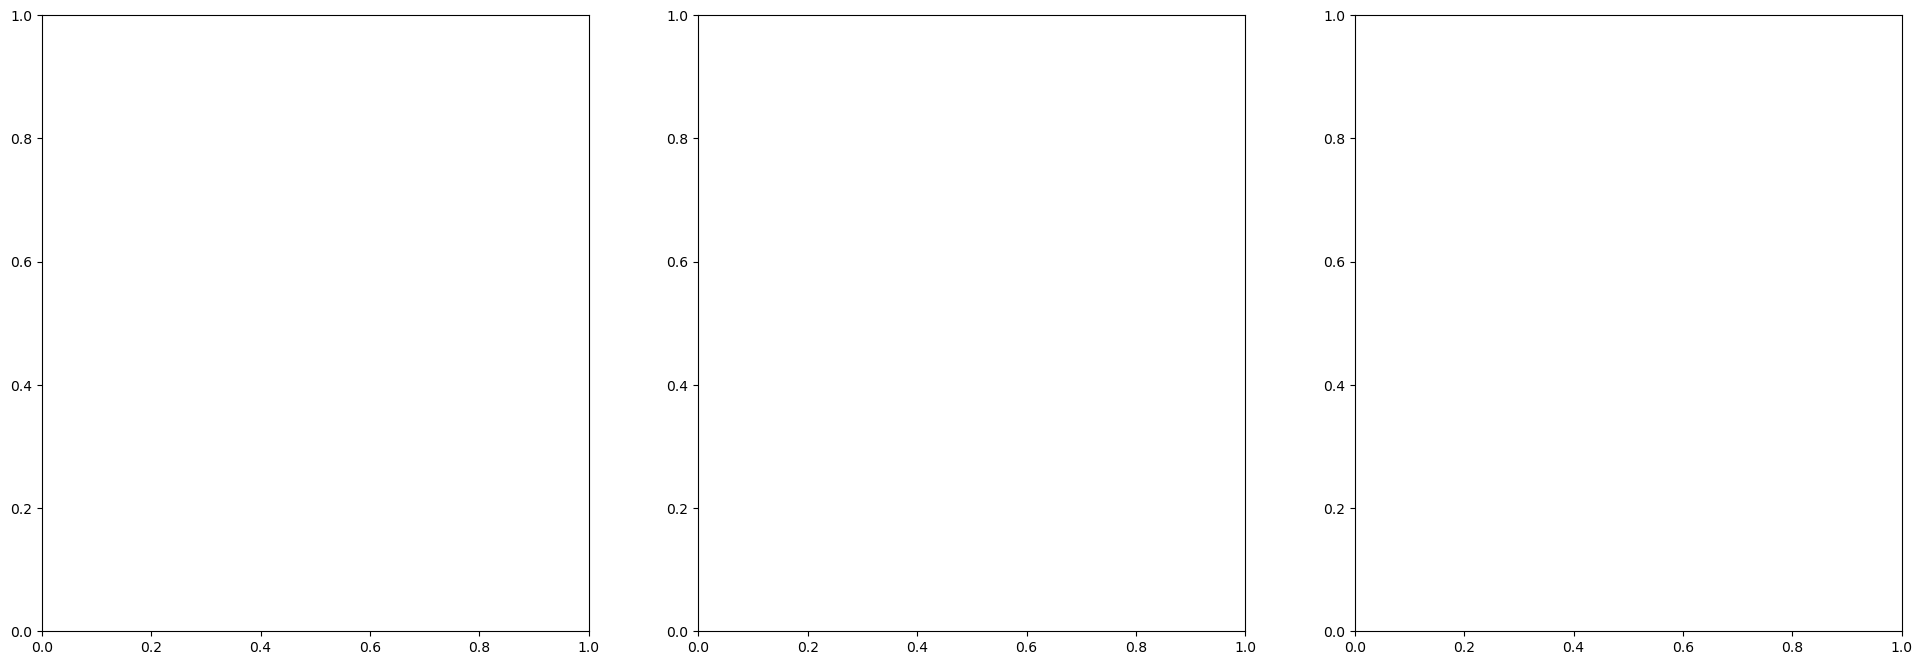

In [48]:
fig, axs = plt.subplots(1,3, figsize=(24, 8))
i= 0

floodmaps = {}


for date in floodmap_names["opera"]:
    path = Path(f"data/2_floodmaps/opera/{date}/floodmap.tif")

    # First, we open the flood map and convert it to the datatype we want.
    floodmap = hydromt.open_raster(path).load().astype(np.int8)
    # floodmap.raster.set_nodata(-1)
    floodmap.raster.set_spatial_dims(x_dim="x", y_dim="y")
    floodmap = floodmap.raster.reproject_like(mod0.grid, method='nearest')


    print(floodmap)
    # Now, we re-map the data to the wanted values.
    floodmap = map_values(data_map, floodmap)

    # floodmap.raster.to_raster(Path(f"data/2_floodmaps/reprojected_maps/opera_{date}.tif"))
    floodmaps[f"opera_{date}"] = floodmap
    
    print(floodmap)
    print(np.unique(floodmap, return_counts=True))
    floodmap.plot(ax=axs[i], cmap=cmap, norm=norm)
    axs[i].set_title(date)
    axs[i].axis("scaled")   
    i+=1


# 1
# Water op -4 en 1, wolken op -3

# 2
# zelfde als 1

# 3
# wolken -3 en -1, water op 1

# for key, floodmap in floodmaps.items():
#     floodmap.plot(ax=axs[i])
#     axs[i].set_title(key)
#     i+=1
#     axs.set_axes("equal")

plt.tight_layout()
plt.show()

### Vector floodmap
UNOSAT has a vector format. Sentinel-2 image was acquired on 26 November 2023 at 10:50 local time. Observation time on 1 December 2023 is unknown.

In [7]:
for date in floodmap_names["unosat"]:
    path = Path(f"data/2_floodmaps/unosat/{date}/floodmap_raster_qgis.tif")
    
    floodmap = hydromt.open_raster(path).load().astype(np.int8)
    floodmap.raster.set_nodata(-1)
    floodmap.raster.set_spatial_dims(x_dim="x", y_dim="y")
    floodmap = floodmap.raster.reproject_like(mod0.grid, method='nearest')
    # floodmap.raster.to_raster(Path(f"data/2_floodmaps/reprojected_maps/unosat_{date}.tif"))

    floodmaps[f"unosat_{date}"] = floodmap

### Plot the flood maps

AttributeError: 'numpy.ndarray' object has no attribute 'set_axes'

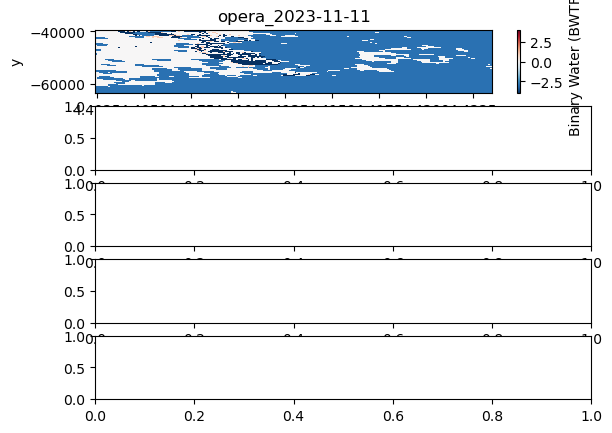

In [16]:
fig, axs = plt.subplots(5)
i=0

for key, floodmap in floodmaps.items():
    floodmap.plot(ax=axs[i])
    axs[i].set_title(key)
    i+=1
    axs.set_axes("equal")
plt.tight_layout()
plt.show()